In [ ]:
!pip install kaggle

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c histopathologic-cancer-detection

100% 6.29G/6.31G [01:15<00:00, 150MB/s]
100% 6.31G/6.31G [01:15<00:00, 90.0MB/s]


In [ ]:
!unzip ./histopathologic-cancer-detection.zip -d ./cancer_data


Streaming output truncated to the last 5000 lines.
  inflating: ./cancer_data/train/fa2c546059bd262cbe954dfdba24dc0d67f598b0.tif  
  inflating: ./cancer_data/train/fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: ./cancer_data/train/fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: ./cancer_data/train/fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: ./cancer_data/train/fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: ./cancer_data/train/fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: ./cancer_data/train/fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: ./cancer_data/train/fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: ./cancer_data/train/fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: ./cancer_data/train/fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: ./cancer_data/train/fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: ./cancer_data/train/fa2eaf8ec6267fa928a88775dc15ee25b633

In [ ]:
import pandas as pd

csv_path = './cancer_data/train_labels.csv'
labels_df = pd.read_csv(csv_path)
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [ ]:
print(labels_df['label'].value_counts())

0    130908
1     89117
Name: label, dtype: int64


<Axes: >

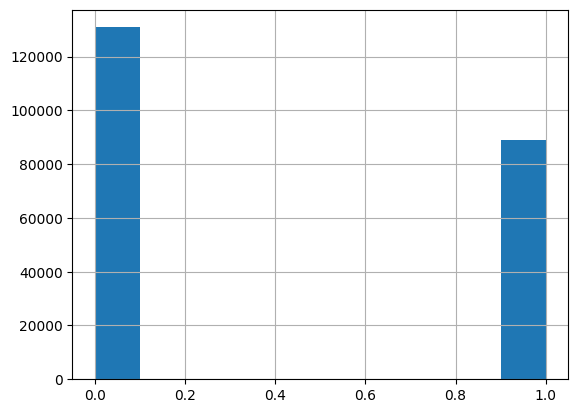

In [ ]:
%matplotlib inline
labels_df['label'].hist()

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import numpy as np
import os
%matplotlib inline


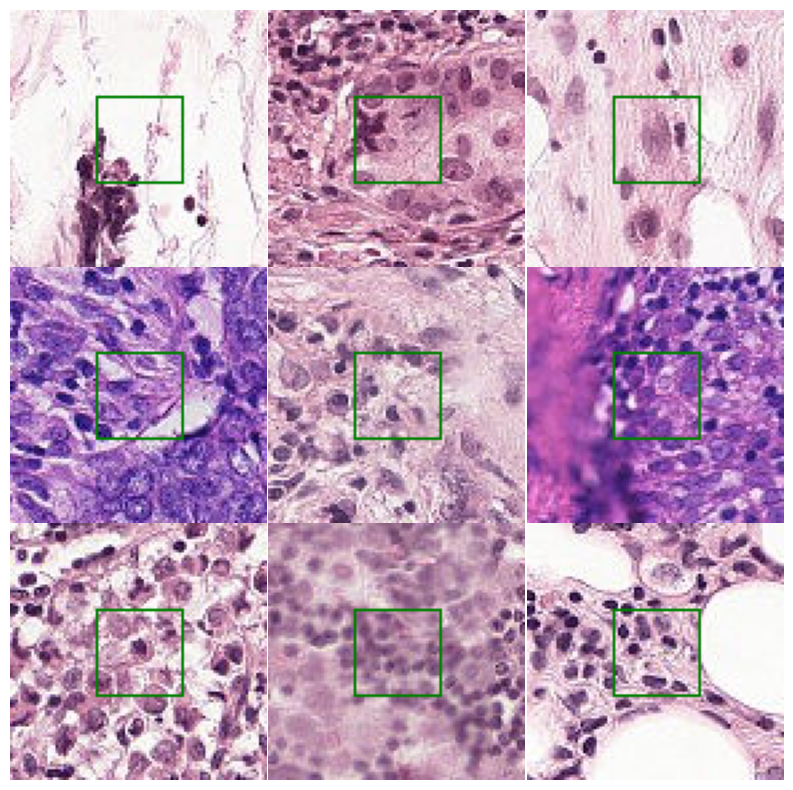

In [ ]:
malignantIds = labels_df.loc[labels_df['label']==1]['id'].values
path2train='./cancer_data/train/'
color=True
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
nrows, ncols = 3, 3

for i, id_ in enumerate(malignantIds[:nrows*ncols]):
  full_filenames = os.path.join(path2train, id_ + '.tif')

  #load image
  try:
    img = Image.open(full_filenames)
    #draw a 32x32 rectangle
    draw = ImageDraw.Draw(img)
    draw.rectangle(((32, 32), (64, 64)), outline='green')
    plt.subplot(nrows, ncols, 1+i)

    if color:
      plt.imshow(np.array(img))
    else:
      plt.imshow(np.array(img)[:,:,0], cmap='gray')

    plt.axis('off')
  except FileNotFoundError:
    print(full_filenames)





In [ ]:
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

torch.manual_seed(0)

In [ ]:
class histoCancerDataset(Dataset):
  def __init__(self, data_dir, transform, data_type='train'):
    path2data = os.path.join(data_dir, data_type)
    filenames = os.listdir(path2data)
    self.full_filenames = [os.path.join(path2data, f) for f in filenames]

    csv_filename = data_type+'_labels.csv'
    path2csvLabels = os.path.join(data_dir, csv_filename)
    labels_df = pd.read_csv(path2csvLabels)

    labels_df.set_index('id', inplace=True)
    self.labels = [labels_df.loc[filename[:-4]].values[0] for filename in filenames]
    self.transform = transform

  def __len__(self):
    return len(self.full_filenames)

  def __getitem__(self, idx):
    image = Image.open(self.full_filenames[idx]) #load .tif file, convert to range [0, 255]
    image = self.transform(image) #convert PIL image to range [0, 1]
    return image, self.labels[idx]


In [ ]:
data_transformer = transforms.Compose([transforms.ToTensor()])
data_dir = './cancer_data/'
histo_dataset = histoCancerDataset(data_dir, data_transformer, 'train')
print(len(histo_dataset))

220025


In [ ]:
img, label = histo_dataset[9]
print(img.shape, torch.min(img), torch.max(img))

torch.Size([3, 96, 96]) tensor(0.) tensor(1.)


In [ ]:
from torch.utils.data import random_split

len_histo = len(histo_dataset)
len_train = int(0.8*len_histo)
len_val = len_histo - len_train

train_ds, val_ds = random_split(histo_dataset, [len_train, len_val])

print("train dataset length:", len(train_ds))
print("validation dataset length:", len(val_ds))

train dataset length: 176020
validation dataset length: 44005


In [ ]:
for x, y in train_ds:
  print(x.shape, y)
  break

for x, y in val_ds:
  print(x.shape, y)
  break

torch.Size([3, 96, 96]) 1
torch.Size([3, 96, 96]) 1


Image Indices:  [ 43567 173685 117952 152315]
torch.Size([3, 100, 394])


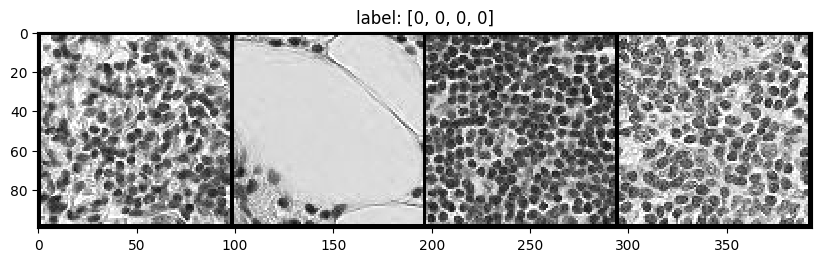

In [ ]:
from torchvision import utils

%matplotlib inline
np.random.seed(0)

def show(img, y, color=False):
  npimg = img.numpy()
  npimg_tr = np.transpose(npimg, (1, 2, 0))

  if color == False:
    npimg_tr = npimg_tr[:, :, 0]
    plt.imshow(npimg_tr, interpolation='nearest', cmap='gray')
  else:
    plt.imshow(npimg_tr, interpolation='nearest')

  plt.title('label: '+str(y))

grid_size = 4
rnd_inds = np.random.randint(0, len(train_ds), grid_size)
print('Image Indices: ', rnd_inds)

x_grid_train = [train_ds[i][0] for i in rnd_inds]
y_grid_train = [train_ds[i][1] for i in rnd_inds]

x_grid_train = utils.make_grid(x_grid_train, nrow=4, padding=2)
print(x_grid_train.shape)

plt.rcParams['figure.figsize'] = (10.0, 5)
show(x_grid_train, y_grid_train)

Image Indices:  [30403 32103 41993 20757]
torch.Size([3, 100, 394])


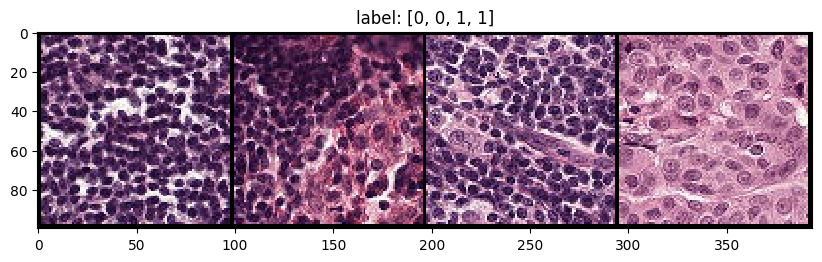

In [ ]:
grid_size = 4
rnd_inds = np.random.randint(0, len(val_ds), grid_size)
print('Image Indices: ', rnd_inds)

x_grid_train = [val_ds[i][0] for i in rnd_inds]
y_grid_train = [val_ds[i][1] for i in rnd_inds]

x_grid_train = utils.make_grid(x_grid_train, nrow=4, padding=2)
print(x_grid_train.shape)

plt.rcParams['figure.figsize'] = (10.0, 5)
show(x_grid_train, y_grid_train, True)

In [ ]:
train_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(45),
    transforms.RandomResizedCrop(96, scale=(0.8,1.0),ratio=(1.0,1.0)),
    transforms.ToTensor(),
])

val_transformer = transforms.Compose([transforms.ToTensor()])

# overwrite
train_ds.transform = train_transformer
val_ds.transform = val_transformer


In [ ]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=64, shuffle=False)


In [ ]:
y_val = [y for _, y in val_ds]

def accuracy(labels, out):
  return np.sum(out==labels)/float(len(labels))

acc_all_zeros = accuracy(y_val, np.zeros_like(y_val))
print("accuracy all zero prediction: %.2f" %acc_all_zeros)

acc_all_ones = accuracy(y_val,np.ones_like(y_val))
print("accuracy all one prediction: %.2f" %acc_all_ones)

acc_random = accuracy(y_val,np.random.randint(2,size=len(y_val)))
print("accuracy random prediction: %.2f" %acc_random)

accuracy all zero prediction: 0.59
accuracy all one prediction: 0.41
accuracy random prediction: 0.49


In [ ]:
import torch.nn as nn

def findConv2dOutShape(H_in, W_in, conv, pool=2):
  kernel_size = conv.kernel_size
  stride = conv.stride
  padding = conv.padding
  dilation = conv.dilation

  H_out = np.floor((H_in + 2 * padding[0] - dilation[0] * (kernel_size[0] - 1) - 1) / stride[0] + 1)
  W_out = np.floor((W_in + 2 * padding[1] - dilation[1] * (kernel_size[1] - 1) - 1) / stride[1] + 1)

  if pool:
    H_out /= pool
    W_out /= pool

  return int(H_out), int(W_out)



In [ ]:
#example
conv1 = nn.Conv2d(3, 8, kernel_size=3)
h,w=findConv2dOutShape(96,96,conv1)
print(h,w)

47 47


In [ ]:
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self, params):
    super(Net, self).__init__()
    C_in, H_in, W_in = params.get('input_shape')
    init_f =  params.get('initial_filters')
    num_fc1 = params.get('num_fc1')
    num_classes = params.get('num_classes')

    self.dropout_rate = params.get('dropout_rate')

    self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3)

    h, w = findConv2dOutShape(H_in, W_in, self.conv1)
    self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)

    h, w = findConv2dOutShape(h, w, self.conv2)
    self.conv3 = nn.Conv2d(2*init_f, 4*init_f,  kernel_size=3)

    h, w = findConv2dOutShape(h, w, self.conv3)
    self.conv4 = nn.Conv2d(4*init_f, 8*init_f,  kernel_size=3)

    h, w = findConv2dOutShape(h, w, self.conv4)

    self.num_flatten = h * w * 8 * init_f
    self.fc1 = nn.Linear(self.num_flatten, num_fc1)
    self.fc2 = nn.Linear(num_fc1, num_classes)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x, 2, 2)
    x = F.relu(self.conv4(x))
    x = F.max_pool2d(x, 2, 2)
    x = x.view(-1, self.num_flatten)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, self.dropout_rate, training=self.training)
    x = self.fc2(x)

    return F.log_softmax(x, dim=1)

params_model = {
    'input_shape': (3, 96, 96),
    'initial_filters': 8,
    'num_fc1': 100,
    'dropout_rate': 0.25,
    'num_classes': 2
}



In [ ]:
cnn_model = Net(params_model)

if torch.cuda.is_available():
  device = torch.device('cuda')
  cnn_model = cnn_model.to(device)

print(cnn_model)



Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)


In [ ]:
print(next(cnn_model.parameters()).device)

cuda:0


In [ ]:
from torchsummary import summary

summary(cnn_model, input_size=(3, 96, 96), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 94, 94]             224
            Conv2d-2           [-1, 16, 45, 45]           1,168
            Conv2d-3           [-1, 32, 20, 20]           4,640
            Conv2d-4             [-1, 64, 8, 8]          18,496
            Linear-5                  [-1, 100]         102,500
            Linear-6                    [-1, 2]             202
Total params: 127,230
Trainable params: 127,230
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.92
Params size (MB): 0.49
Estimated Total Size (MB): 1.51
----------------------------------------------------------------


In [ ]:
loss_func = nn.NLLLoss(reduction='sum')

In [ ]:
#example

torch.manual_seed(0)

n, c = 8, 2
y = torch.randn(n, c, requires_grad=True)
ls_F = nn.LogSoftmax(dim=1)
y_out = ls_F(y)
print(y_out.shape)

target = torch.randint(c, size=(n,))
print(target.shape)

loss = loss_func(y_out, target)
print(loss.item())

loss.backward()
print(y.data)


torch.Size([8, 2])
torch.Size([8])
5.266995429992676
tensor([[-1.1258, -1.1524],
        [-0.2506, -0.4339],
        [ 0.8487,  0.6920],
        [-0.3160, -2.1152],
        [ 0.3223, -1.2633],
        [ 0.3500,  0.3081],
        [ 0.1198,  1.2377],
        [ 1.1168, -0.2473]])


In [ ]:
print(cnn_model.parameters())

<generator object Module.parameters at 0x7b1a41f1b990>


In [ ]:
from torch import optim

opt = optim.Adam(cnn_model.parameters(), lr=3e-4)

#get learning rate
def get_lr(opt):
  for param_group in opt.param_groups:
    return param_group['lr']

current_lr = get_lr(opt)
print('current_lr = {}'.format(current_lr))


current_lr = 0.0003


In [ ]:
#learning scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(opt, mode='min',
                                 factor=0.5, patience=20, verbose=1)

for i in range(100):
  lr_scheduler.step(i)

Epoch 00022: reducing learning rate of group 0 to 1.5000e-04.
Epoch 00043: reducing learning rate of group 0 to 7.5000e-05.
Epoch 00064: reducing learning rate of group 0 to 3.7500e-05.
Epoch 00085: reducing learning rate of group 0 to 1.8750e-05.


In [ ]:
import copy
#helpers
def metrics_batch(output, target):
  pred = output.argmax(dim=1, keepdim=True)
  corrects = pred.eq(target.view_as(pred)).sum().item()
  return corrects

def loss_batch(loss_func, output, target, opt=None):
  loss = loss_func(output, target)
  with torch.no_grad():
    metric_b = metrics_batch(output, target)
  if opt is not None:
    opt.zero_grad()
    loss.backward()
    opt.step()
  return loss.item(), metric_b

def loss_epoch(model, loss_func, dataset_dl, sanity_check=False, opt=None):
  running_loss = 0.0
  running_metric = 0.0
  len_data = len(dataset_dl.dataset)

  for xb, yb, in dataset_dl:
    #batch
    xb = xb.to(device)
    yb = yb.to(device)

    #model output
    output = model(xb)

    loss_b, metric_b = loss_batch(loss_func, output, yb, opt)

    running_loss += loss_b
    if metric_b is not None:
      running_metric += metric_b

    if sanity_check is True: #Just to check if it's working lol
      break

  loss = running_loss/float(len_data)
  metric = running_metric/float(len_data)

  return loss, metric

def train_val(model, params):
  num_epochs = params.get('num_epochs')
  loss_func = params.get('loss_func')
  opt = params.get('optimizer')
  train_dl = params.get('train_dl')
  val_dl = params.get('val_dl')
  sanity_check = params.get('sanity_check')
  lr_scheduler = params.get('lr_scheduler')
  path2weights = params.get('path2weights')

  loss_history = {
      'train': [],
      'val': [],
  }

  metric_history = {
      'train': [],
      'val': [],
  }


  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = float('inf')

  #main loop
  for epoch in range(num_epochs):
    current_lr = get_lr(opt)
    print('Epoch {}/{} -- current lr = {}'.format(epoch, num_epochs-1, current_lr))
    model.train()
    train_loss, train_metric = loss_epoch(model, loss_func, train_dl, sanity_check, opt)

    loss_history['train'].append(train_loss)
    metric_history['train'].append(train_metric)

    model.eval()
    with torch.no_grad():
      val_loss, val_metric = loss_epoch(model, loss_func, val_dl, sanity_check)
      loss_history['val'].append(val_loss)
      metric_history['val'].append(val_metric)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(model.state_dict(), path2weights)
      print("Copied best model weights!")

    lr_scheduler.step(val_loss)
    if current_lr != get_lr(opt):
      print('Loading Best Model Weights!')
      model.load_state_dict(best_model_wts)

    print("train loss: %.6f, val loss: %.6f, accuracy: %.2f" % (train_loss,val_loss,100*val_metric))
    print("-"*10)

  model.load_state_dict(best_model_wts)
  return model, loss_history, metric_history




In [ ]:
params_train={
 "num_epochs": 2,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "sanity_check": False,
 "lr_scheduler": lr_scheduler,
 "path2weights": "./models/weights.pt",
}

cnn_model, loss_hist, metric_hist = train_val(cnn_model, params_train)

Epoch 0/1 -- current lr = 1.875e-05
Copied best model weights!
train loss: 0.460677, val loss: 0.451528, accuracy: 79.62
----------
Epoch 1/1 -- current lr = 1.875e-05
Copied best model weights!
train loss: 0.455529, val loss: 0.446172, accuracy: 79.85
----------


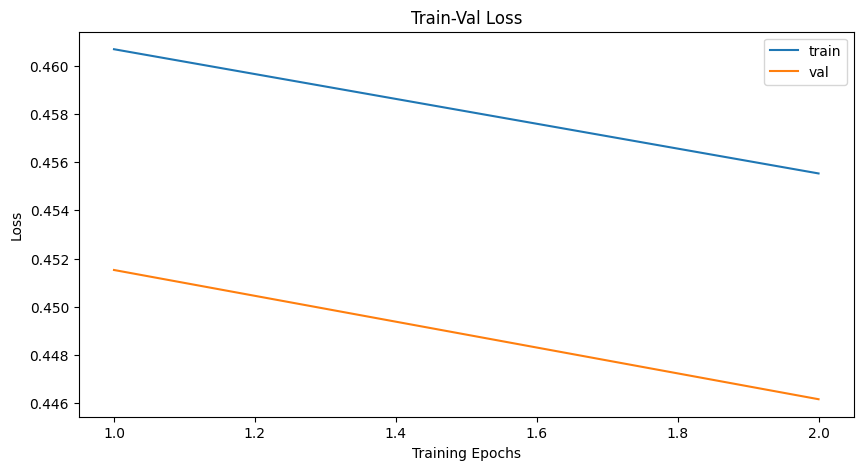

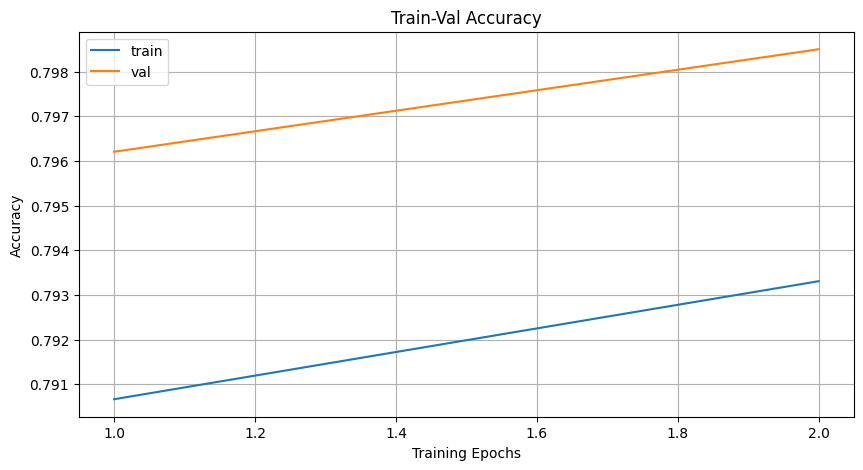

In [ ]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]
# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.grid()
plt.show()

Deploying the model : )

In [ ]:
#create objects of Net class and load stored weights into the model

params = {
    'input_shape': (3, 96, 96),
    'initial_filters': 8,
    'num_fc1': 100,
    'dropout_rate': 0.25,
    'num_classes': 2
}

cnn_model = Net(params_model)

In [ ]:
#load state_dict into model
path2weights = "./models/weights.pt"

cnn_model.load_state_dict(torch.load(path2weights))

<All keys matched successfully>

In [ ]:
cnn_model.eval()

Net(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [ ]:
import time

if torch.cuda.is_available():
  device = torch.device('cuda')
  cnn_model = cnn_model.to(device)

def deploy_model(model, dataset, device, num_classes=2, sanity_check=False):
  len_data = len(dataset)
  #init output tensor on CPU: because of GPU memory limits
  y_out = torch.zeros(len_data, num_classes)
  #init ground truth on CPU: still because of GPU memory limits
  y_gt = np.zeros((len_data), dtype='uint8')
  #move model to device
  model=model.to(device)

  elapsed_times = []
  with torch.no_grad():
    for i in range(len_data):
      x, y = dataset[i]
      y_gt[i] = y
      start = time.time()
      y_out[i] = model(x.unsqueeze(0).to(device))
      elapsed=time.time()-start
      elapsed_times.append(elapsed)
      if sanity_check is True:
        break

    inference_time = np.mean(elapsed_times) * 1000
    print('average inference time per image on %s: %.2f ms' %(device, inference_time))
    return y_out.numpy(), y_gt


In [ ]:
y_out, y_gt = deploy_model(cnn_model, val_ds, device=device)
print(y_out.shape, y_gt.shape)

average inference time per image on cuda: 0.90 ms
(44005, 2) (44005,)


In [ ]:
from sklearn.metrics import accuracy_score

y_pred = np.argmax(y_out, axis=1)
print(y_pred.shape, y_gt.shape)

acc = accuracy_score(y_pred, y_gt)
print('accuracy: %.2f' %acc)

(44005,) (44005,)
accuracy: 0.80


In [ ]:
device_cpu = torch.device('cpu')
y_out, y_gt = deploy_model(cnn_model, val_ds, device=device_cpu)
print(y_out.shape, y_gt.shape)

average inference time per image on cpu: 2.08 ms
(44005, 2) (44005,)
